In [1]:
import pandas as pd


def extract_and_save_metabolites(df, output_file_path, metabolite_titles):
    """
    Extracts metabolites and their production over time from different compartments,
    and saves the data into a CSV file in the specified format.

    Parameters:
    df (DataFrame): The DataFrame containing the metabolite data.
    output_file_path (str): The file path to save the new CSV file.
    metabolite_titles (dict): A dictionary mapping metabolite identifiers to their full names.
    """
    # Create a new DataFrame to store the extracted data
    extracted_data = pd.DataFrame(columns=['day', 'flux', 'compartment', 'metabolite'])

    # Loop through each metabolite identifier and its full name
    for met_id, met_name in metabolite_titles.items():
        # Filter data specifically for the exact metabolite identifier
        metabolite_data = df[df['metabolite'] == met_id].copy()

        # Extract the day information from the sample_id
        metabolite_data['day'] = metabolite_data['sample_id'].str.extract(r'_Day(\d+)')[0].astype(int)

        # Add compartment information
        metabolite_data['compartment'] = metabolite_data['sample_id'].str.extract(r'(\D+)_Day\d+')[0]

        # Keep only the necessary columns and rename the flux column
        metabolite_data = metabolite_data[['day', 'flux', 'compartment']].copy()
        metabolite_data.rename(columns={'flux': 'flux'}, inplace=True)
        metabolite_data['metabolite'] = met_name

        # Append to the extracted_data DataFrame
        extracted_data = pd.concat([extracted_data, metabolite_data], ignore_index=True)

    # Save the extracted data to a CSV file
    extracted_data.to_csv(output_file_path, index=False)

# Define the mapping of metabolite identifiers to their full names
metabolite_titles = {
    'but_m': 'Butyrate', 
    'isobut_m': 'Isobutyrate', 
    'isoval_m': 'Isovalerate', 
    'ac_m': 'Acetate', 
    'ppa_m': 'Propionate'
}

# Example usage:
df = pd.read_csv("./exchanges_diet2_08.csv")  # Load your data into a DataFrame
extract_and_save_metabolites(df, "./Diet_2_08.csv", metabolite_titles)


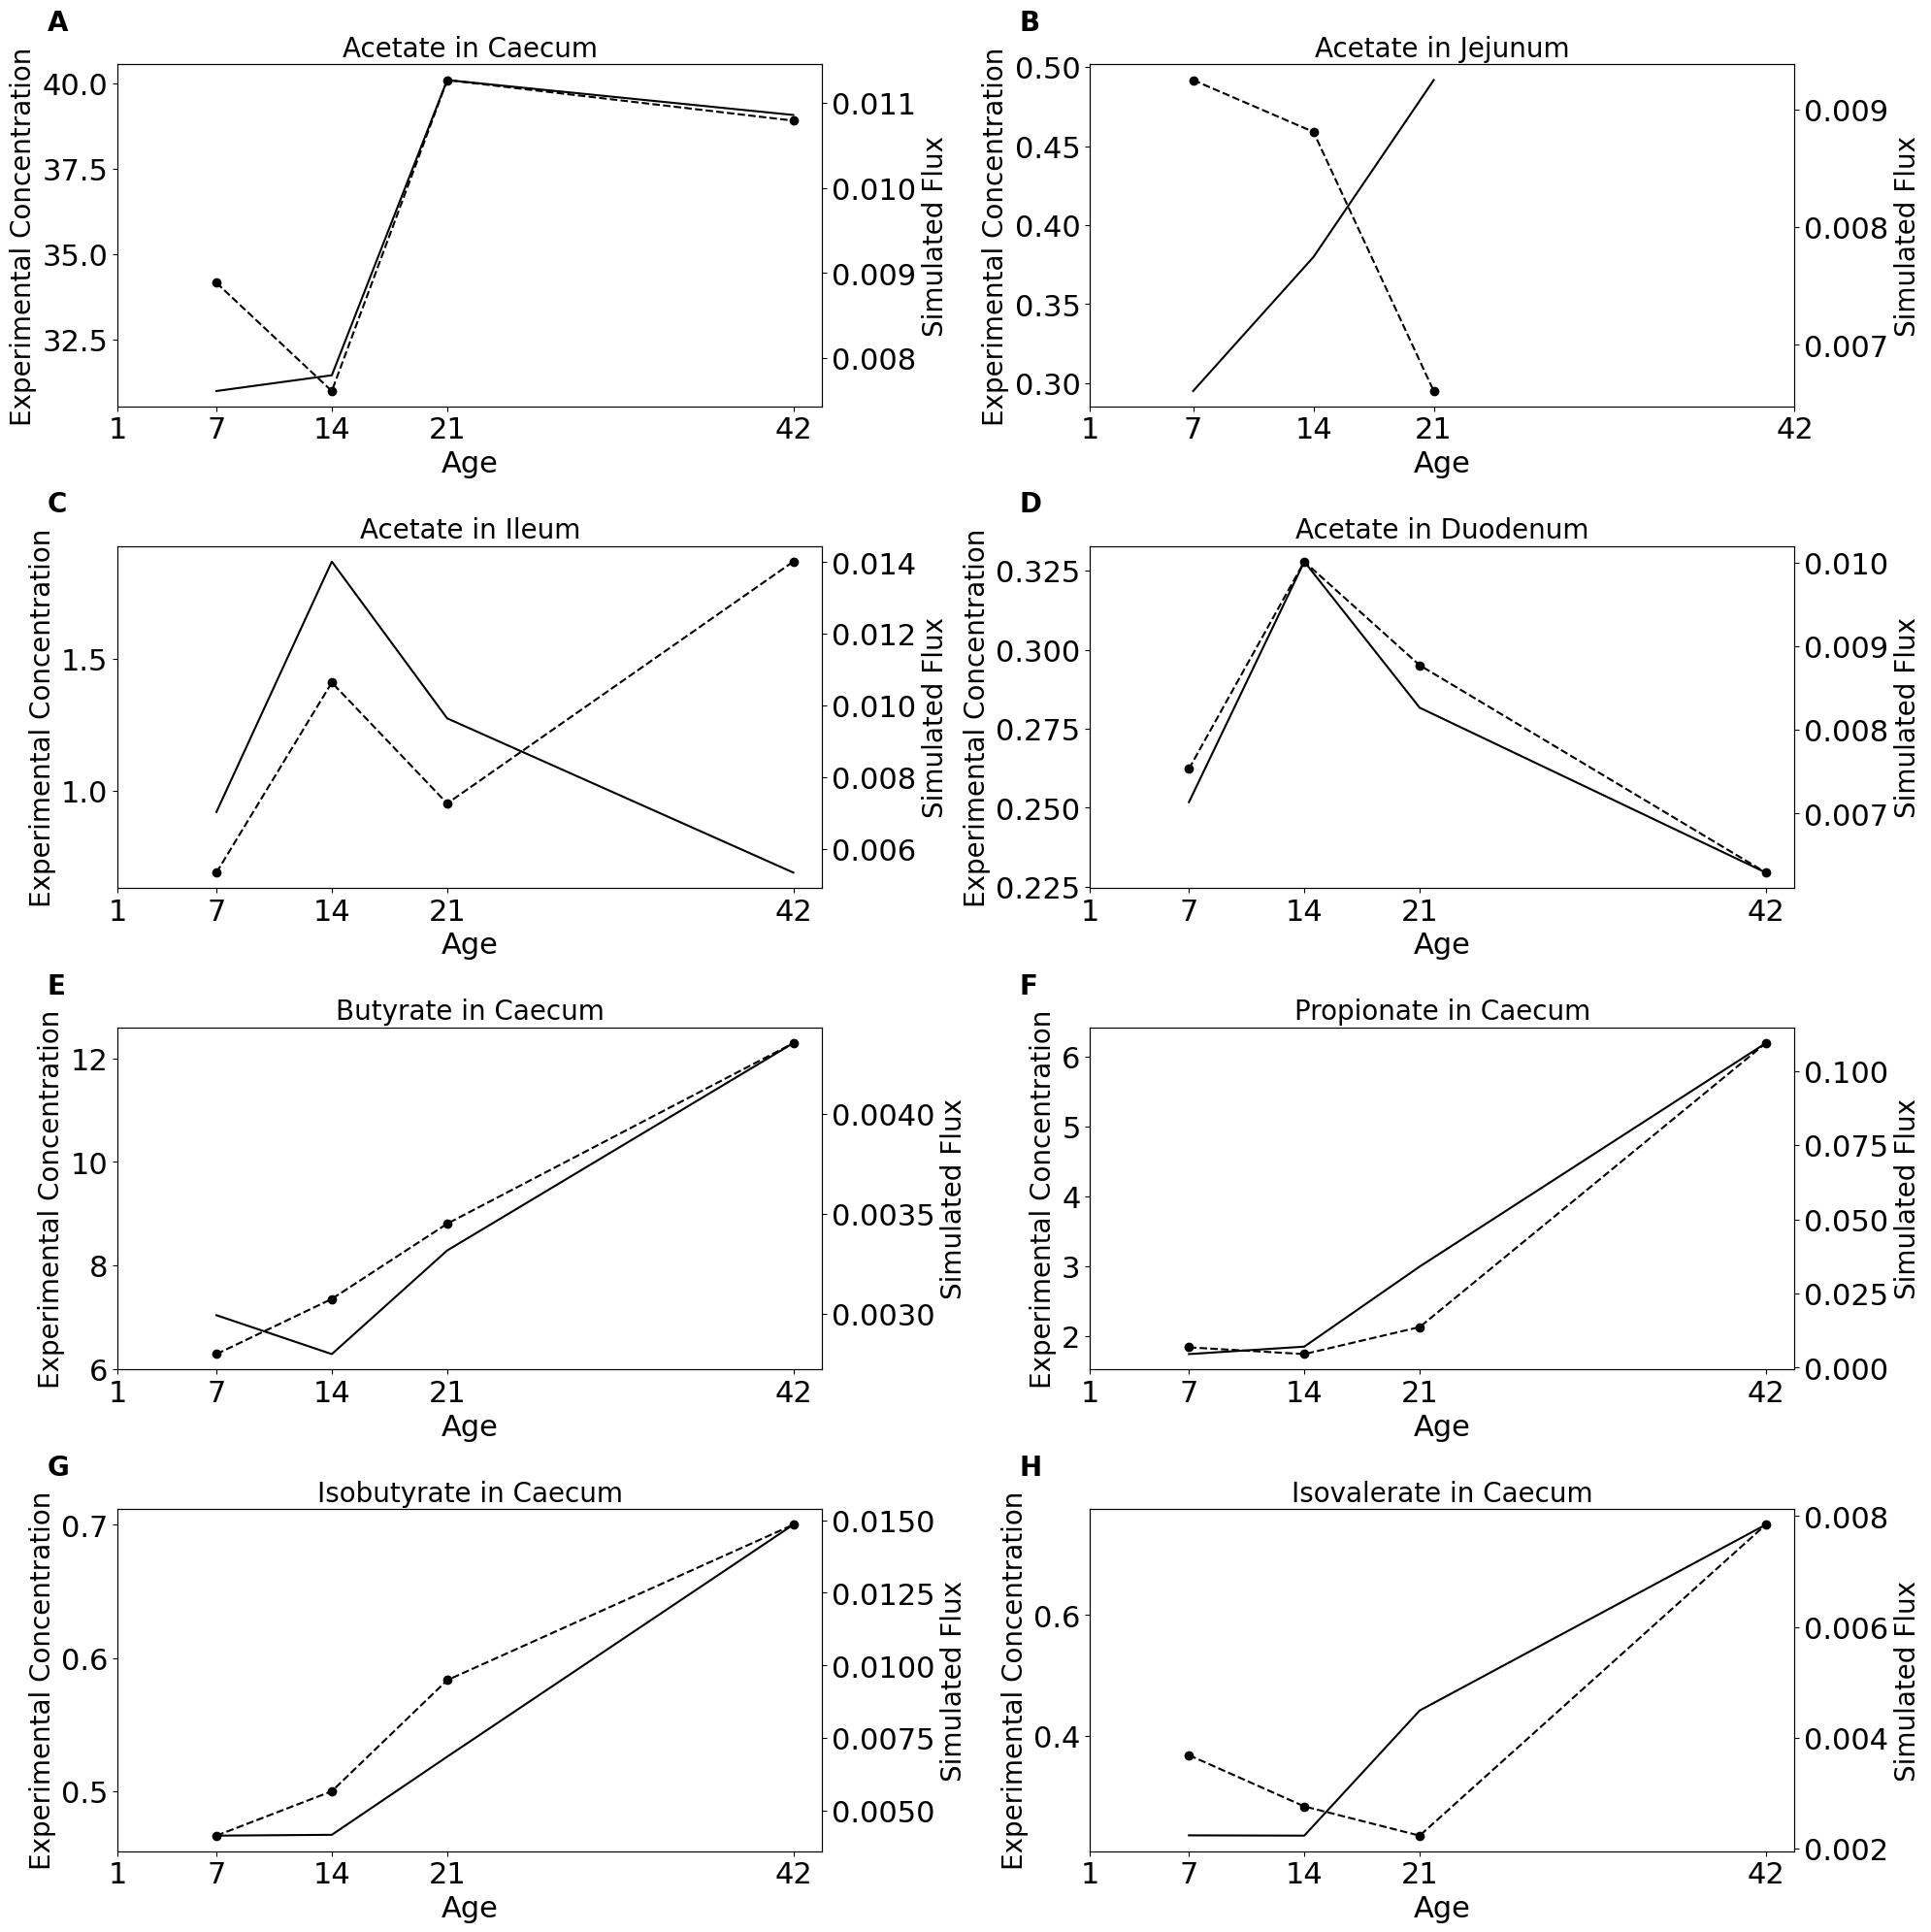

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from string import ascii_uppercase

def plot_on_subplot(ax, exp_data, sim_data, metabolite, compartment):
    common_days = set(exp_data['day']).intersection(set(sim_data['day']))

    # Filter data based on common days
    exp_data_filtered = exp_data[exp_data['day'].isin(common_days)]
    sim_data_filtered = sim_data[sim_data['day'].isin(common_days)]
    # Filter relevant data for plotting
    exp_days = exp_data_filtered['day']
    exp_concentration = exp_data_filtered['Concentration']
    sim_days = sim_data_filtered['day']
    sim_flux = sim_data_filtered['flux']

    # Plot experimental concentration and simulated flux
    ax.set_xlabel('Age', fontsize=22)
    ax.set_ylabel('Experimental Concentration', color='black', fontsize=20)
    ax.plot(exp_days, exp_concentration, color='black', marker='o', linestyle='dashed', label='Experimental Concentration')
    ax.tick_params(axis='y', labelcolor='black', labelsize=22)
    ax.tick_params(axis='x', labelsize=22)

    ax2 = ax.twinx()
    ax2.set_ylabel('Simulated Flux', color='black', fontsize=20)
    ax2.plot(sim_days, sim_flux, color='black', linestyle='-', label='Simulated Flux')
    ax2.tick_params(axis='y', labelcolor='black', labelsize=22)
    ax.set_xticks([1, 7, 14, 21, 42])
    ax.set_xticklabels(['1', '7', '14', '21', '42'])
    #ax.legend()  

    ax.set_title(f"{metabolite} in {compartment}", fontsize=20)
    ax.grid(False)
    ax2.grid(False)

# Load the data (update these file paths!)
experimental_data_path = './Experimental_data.csv' 
simulated_data_path = './Diet_2_07.csv'  
exp_data = pd.read_csv(experimental_data_path)
sim_data = pd.read_csv(simulated_data_path)
exp_data = exp_data.sort_values(by='day')
sim_data = sim_data.sort_values(by='day')

# Identify relevant combinations 
relevant_combinations = []
for metabolite in exp_data['metabolite'].unique():
    for compartment in exp_data['compartment'].unique():
        # Match based on metabolite and compartment 
        exp_subset = exp_data[(exp_data['metabolite'] == metabolite) & (exp_data['compartment'] == compartment)]
        sim_subset = sim_data[(sim_data['metabolite'] == metabolite) & (sim_data['compartment'] == compartment)] 

        if not exp_subset.empty and not sim_subset.empty:
            relevant_combinations.append((metabolite, compartment))

# Create figure with multiple subplots
n_subplots = len(relevant_combinations)
n_cols = 2  # Adjust based on preference and screen size
n_rows = n_subplots // n_cols + (n_subplots % n_cols > 0)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10 * n_cols, 5 * n_rows))
axs = axs.flatten()  

# Plot data on each subplot
for i, (metabolite, compartment) in enumerate(relevant_combinations):
    exp_plot_data = exp_data[(exp_data['metabolite'] == metabolite) & (exp_data['compartment'] == compartment)]
    sim_plot_data = sim_data[(sim_data['metabolite'] == metabolite) & (sim_data['compartment'] == compartment)]
    plot_on_subplot(axs[i], exp_plot_data, sim_plot_data, metabolite, compartment)
    axs[i].text(-0.1, 1.1, ascii_uppercase[i], transform=axs[i].transAxes, size=20, weight='bold')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [2]:
## import pandas as pd
import matplotlib.pyplot as plt
from string import ascii_uppercase
import numpy as np
from scipy.stats import pearsonr

def calculate_pearson_correlations(exp_data, sim_data):
    correlation_results = []
    for metabolite in exp_data['metabolite'].unique():
        for compartment in exp_data['compartment'].unique():
            exp_subset = exp_data[(exp_data['metabolite'] == metabolite) & (exp_data['compartment'] == compartment)]
            sim_subset = sim_data[(sim_data['metabolite'] == metabolite) & (sim_data['compartment'] == compartment)]

            if not exp_subset.empty and not sim_subset.empty:
                common_days = set(exp_subset['day']).intersection(set(sim_subset['day']))
                exp_subset_filtered = exp_subset[exp_subset['day'].isin(common_days)]
                sim_subset_filtered = sim_subset[sim_subset['day'].isin(common_days)]

                # Handle potential infinities 
                exp_subset_filtered['Concentration'].replace([np.inf, -np.inf], np.nan, inplace=True)
                sim_subset_filtered['flux'].replace([np.inf, -np.inf], np.nan, inplace=True)

                # Calculate correlation (dropna handles missing values)
                pearson_corr, pearson_pval = pearsonr(exp_subset_filtered['Concentration'], sim_subset_filtered['flux'])

                n_observations = len(exp_subset_filtered.dropna())

                correlation_results.append({
                    'Compartment': compartment,
                    'Metabolite': metabolite,
                    'Pearson Correlation': pearson_corr,
                    'P-Value': pearson_pval,
                    'N': n_observations 
                })

    return pd.DataFrame(correlation_results)



# Calculate correlations
correlation_df = calculate_pearson_correlations(exp_data, sim_data)

# Display the DataFrame
print(correlation_df)

  Compartment   Metabolite  Pearson Correlation   P-Value  N
0      Caecum      Acetate             0.939041  0.060959  4
1     Jejunum      Acetate            -0.958887  0.183182  3
2       Ileum      Acetate            -0.093108  0.906892  4
3    Duodenum      Acetate             0.986336  0.013664  4
4      Caecum     Butyrate             0.957534  0.042466  4
5      Caecum   Propionate             0.979014  0.020986  4
6      Caecum  Isobutyrate             0.967734  0.032266  4
7      Caecum  Isovalerate             0.816929  0.183071  4


/tmp/ipykernel_6448/1925911845.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_subset_filtered['Concentration'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_6448/1925911845.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim_subset_filtered['flux'].replace([np.inf, -np.inf], np.nan, inplace=True)


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from string import ascii_uppercase
import numpy as np
from scipy.stats import pearsonr

# Function to read CSV file and return DataFrame
def read_csv_file(file_name):
    try:
        return pd.read_csv(file_name)
    except FileNotFoundError:
        print(f"File {file_name} not found.")
        return None

# Function to calculate Pearson correlations
def calculate_pearson_correlations(exp_data, sim_data):
    correlation_results = []
    metabolites = set(exp_data['metabolite']).union(set(sim_data['metabolite']))
    compartments = set(exp_data['compartment']).union(set(sim_data['compartment']))

    for metabolite in metabolites:
        for compartment in compartments:
            exp_subset = exp_data[(exp_data['metabolite'] == metabolite) & (exp_data['compartment'] == compartment)]
            sim_subset = sim_data[(sim_data['metabolite'] == metabolite) & (sim_data['compartment'] == compartment)]

            if not exp_subset.empty and not sim_subset.empty:
                common_days = set(exp_subset['day']).intersection(set(sim_subset['day']))
                exp_subset_filtered = exp_subset[exp_subset['day'].isin(common_days)]
                sim_subset_filtered = sim_subset[sim_subset['day'].isin(common_days)]

                # Handle potential infinities 
                exp_subset_filtered['Concentration'].replace([np.inf, -np.inf], np.nan, inplace=True)
                sim_subset_filtered['flux'].replace([np.inf, -np.inf], np.nan, inplace=True)

                # Calculate correlation (dropna handles missing values)
                if not exp_subset_filtered.empty and not sim_subset_filtered.empty:
                    pearson_corr, pearson_pval = pearsonr(exp_subset_filtered['Concentration'].dropna(), sim_subset_filtered['flux'].dropna())

                    n_observations = len(exp_subset_filtered.dropna())

                    correlation_results.append({
                        'Compartment': compartment,
                        'Metabolite': metabolite,
                        'Pearson Correlation': pearson_corr,
                        'P-Value': pearson_pval,
                        'N': n_observations 
                    })

    return pd.DataFrame(correlation_results)

# Specify CSV file names
exp_data_file = 'Experimental_data.csv' # Replace with actual file name
sim_data_file = 'Diet2.csv' # Replace with actual file name

# Read CSV files
exp_data = read_csv_file(exp_data_file)
sim_data = read_csv_file(sim_data_file)

# Check if both dataframes are loaded
if exp_data is not None and sim_data is not None:
    # Calculate correlations
    correlation_df = calculate_pearson_correlations(exp_data, sim_data)

    # Display the DataFrame
    print(correlation_df)
else:
    print("Error: One or both data files could not be loaded.")


  Compartment   Metabolite  Pearson Correlation   P-Value  N
0      Caecum     Butyrate            -0.064848  0.935152  4
1      Caecum   Propionate            -0.397136  0.602864  4
2      Caecum  Isobutyrate            -0.024833  0.975167  4
3      Caecum  Isovalerate            -0.574384  0.425616  4
4      Caecum      Acetate             0.216799  0.783201  4
5       Ileum      Acetate            -0.815936  0.184064  4
6     Jejunum      Acetate             0.725210  0.483485  3
7    Duodenum      Acetate             0.243810  0.756190  4


/tmp/ipykernel_5381/303497615.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_subset_filtered['Concentration'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_5381/303497615.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim_subset_filtered['flux'].replace([np.inf, -np.inf], np.nan, inplace=True)
